Epoch 1: Loss: 0.7386, Val Loss: 0.7262, Acc: 0.2154, Val Acc: 0.2116
Epoch 2: Loss: 0.7260, Val Loss: 0.7164, Acc: 0.2154, Val Acc: 0.2116
Epoch 3: Loss: 0.7165, Val Loss: 0.7095, Acc: 0.2154, Val Acc: 0.2116
Epoch 4: Loss: 0.7095, Val Loss: 0.7042, Acc: 0.2155, Val Acc: 0.2116
Epoch 5: Loss: 0.7042, Val Loss: 0.7000, Acc: 0.2332, Val Acc: 0.2106
Epoch 6: Loss: 0.7001, Val Loss: 0.6965, Acc: 0.3779, Val Acc: 0.2591
Epoch 7: Loss: 0.6961, Val Loss: 0.6928, Acc: 0.5695, Val Acc: 0.5147
Epoch 8: Loss: 0.6926, Val Loss: 0.6887, Acc: 0.6509, Val Acc: 0.7448
Epoch 9: Loss: 0.6884, Val Loss: 0.6840, Acc: 0.6720, Val Acc: 0.7860
Epoch 10: Loss: 0.6836, Val Loss: 0.6784, Acc: 0.6751, Val Acc: 0.7883
Epoch 11: Loss: 0.6783, Val Loss: 0.6721, Acc: 0.6755, Val Acc: 0.7884
Epoch 12: Loss: 0.6723, Val Loss: 0.6650, Acc: 0.6755, Val Acc: 0.7884
Epoch 13: Loss: 0.6653, Val Loss: 0.6572, Acc: 0.6783, Val Acc: 0.7884
Epoch 14: Loss: 0.6581, Val Loss: 0.6487, Acc: 0.6766, Val Acc: 0.7884
Epoch 15: Loss:

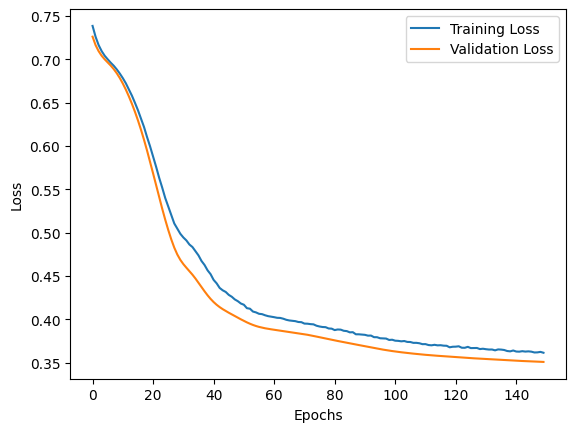

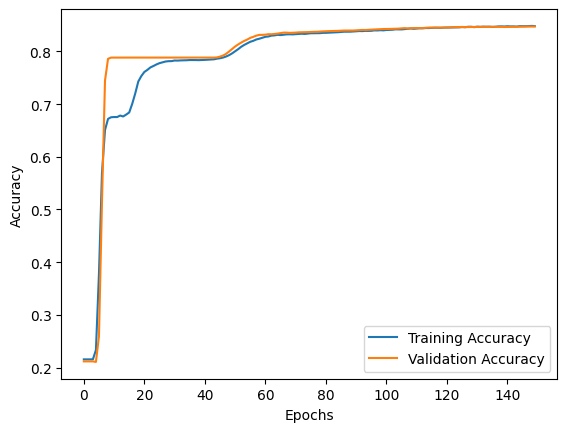

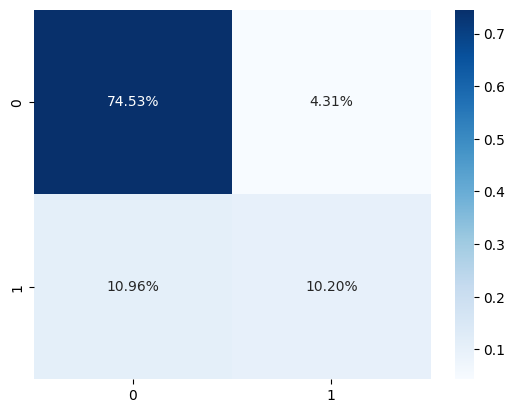

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Set seed for reproducibility
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load dataset
features = pd.read_csv("weatherAUS_cleaned.csv")
X = features.drop(["RainTomorrow"], axis=1).values
y = features["RainTomorrow"].values

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define Neural Network Model
class RainPredictionNN(nn.Module):
    def __init__(self, input_dim):
        super(RainPredictionNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 126),
            nn.ReLU(),
            nn.Linear(126,115),
            nn.ReLU(),
            nn.Linear(115, 49),
            nn.ReLU(),
            nn.Dropout(0.11),
            nn.Linear(49, 8),
            nn.ReLU(),
            nn.Dropout(0.19),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize model
input_dim = X_train.shape[1]
model = RainPredictionNN(input_dim)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Training loop
epochs = 150
best_loss = float('inf')
patience = 20
counter = 0
history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        
        # Calculate accuracy
        train_acc = ((outputs > 0.5) == y_train).float().mean().item()
        val_acc = ((val_outputs > 0.5) == y_test).float().mean().item()
        
        history["loss"].append(loss.item())
        history["val_loss"].append(val_loss.item())
        history["accuracy"].append(train_acc)
        history["val_accuracy"].append(val_acc)
    
    print(f"Epoch {epoch+1}: Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    
    # Early stopping
    if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

# Plot Training & Validation Loss
plt.plot(history["loss"], label='Training Loss')
plt.plot(history["val_loss"], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Training & Validation Accuracy
plt.plot(history["accuracy"], label='Training Accuracy')
plt.plot(history["val_accuracy"], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict and compute confusion matrix
model.eval()
with torch.no_grad():
    y_pred = model(X_test) > 0.5
cf_matrix = confusion_matrix(y_test.numpy(), y_pred.numpy())
sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()
